In [ ]:
summoner='5bP75FEeodLSJd1NcQlO9aL0G8vrjYiD8lAP1nw5X6yUtECy'
match = na_matches[0]
timeline = na_timelines[0]
summoner in [summoner['player']['summonerId'] for summoner in match['participantIdentities']]

In [ ]:
x = pd.DataFrame(columns=['i','am','dumb'])

x = x.append({'i':1,'am':2,'dumb':3}, ignore_index=True)
x = x.append({'i':1,'am':3,'dumb':4}, ignore_index=True)
x = x.append({'i':'lol','am':3,'dumb':4}, ignore_index=True)


x.head()

In [ ]:
x['i'].value_counts().index[0]

In [ ]:
pd.DataFrame(x.mean()).transpose()

In [ ]:
match['teams']

In [ ]:
player_id = 9
match['participants'][player_id]['timeline']

In [ ]:
timeline['frames'][10]['events']

In [7]:
def get_stats(summoner, region, matches, timelines, team_participants = ([1,2,3,4,5],[6,7,8,9,10])):
# For each player:
    output = pd.DataFrame(columns=['champ_played', 'role','lane', 'csd_10',
                                  'gold_d_10','xpd_10','dmg_share','dmg_taken_share','vision_score',
                                  'kill_participation','obj_dmg_share','dragons','barons','wards_cleared',
                                  'vision_wards_purchased','kda_early', 'kda_mid', 'kda_late', 
                                   'solo_kills', 'teamfight_kills', 'skirmish_kills', 'wards_early', 
                                   'wards_mid', 'wards_late'])
    # Main role = most played role where role is played > 40% of the time
    # Main champion = most played champion
    # Select all matches and timelines that they are in
    for i, match in enumerate(matches):
        is_in_game = summoner in [summoner['player']['summonerId'] for summoner in match['participantIdentities']]
        if is_in_game:
        # For each match:
        # Match info:
            game_id = match['gameId']
            player_id = int([player['participantId'] for player in match['participantIdentities'] if player['player']['summonerId'] == summoner][0]) - 1
            player_name = match['participantIdentities'][player_id]['player']['summonerName']
            
            # Identify champion played
            champ_played = match['participants'][player_id]['championId']
            
            # Identify role played
            role = match['participants'][player_id]['timeline']['role']
            lane = match['participants'][player_id]['timeline']['lane']
            # Identify lane opponent
            team = match['participants'][player_id]['teamId']
            team_index = int(str(team)[0]) - 1
            teammates = team_participants[team_index]
               
            # Get CSD, GoldD and XPD @ 10
            csd_10 = match['participants'][player_id]['timeline']['creepsPerMinDeltas']['0-10']
            gold_d_10 = match['participants'][player_id]['timeline']['goldPerMinDeltas']['0-10']
            xpd_10 = match['participants'][player_id]['timeline']['xpPerMinDeltas']['0-10']
            
            # Get DMG share
            total_dmg = np.sum([player['stats']['totalDamageDealtToChampions'] for player in match['participants'] if player['teamId'] == team])
            dmg_share = match['participants'][player_id]['stats']['totalDamageDealtToChampions'] / total_dmg
            
            # Get DMG Taken share
            total_dmg_taken = np.sum([player['stats']['totalDamageTaken'] for player in match['participants'] if player['teamId'] == team])
            dmg_taken_share = match['participants'][player_id]['stats']['totalDamageTaken'] / total_dmg_taken
            
            # Get vision score
            vision_score = match['participants'][player_id]['stats']['visionScore']
            
            # Get overall kill participation
            team_kills = np.sum([player['stats']['kills'] for player in match['participants'] if player['participantId'] in teammates]) + 1
            kill_participation = (match['participants'][player_id]['stats']['kills'] + match['participants'][player_id]['stats']['assists']) / team_kills
            
            # % of team's objective damage % of team's turret damage
            total_obj_dmg = np.sum([player['stats']['damageDealtToObjectives'] for player in match['participants'] if player['teamId'] == team])
            obj_dmg_share = match['participants'][player_id]['stats']['damageDealtToObjectives'] / total_obj_dmg
            
            # Team % of dragons killed
            team_dragons = match['teams'][team_index]['dragonKills']
            total_dragons = team_dragons + match['teams'][0 if team_index == 1 else 1]['dragonKills']
            dragons = team_dragons / (total_dragons + 1)
            
            # Team % of barons killed
            team_barons = match['teams'][team_index]['baronKills']
            total_barons = team_barons + match['teams'][0 if team_index == 1 else 1]['baronKills']
            barons = team_barons / (total_barons + 1)
            
            # Get wards cleared
            wards_cleared = match['participants'][player_id]['stats']['wardsKilled']
            
            # Get pinks purchased
            vision_wards_purchased = match['participants'][player_id]['stats']['visionWardsBoughtInGame']
            
            # For each timeline:
            timeline = timelines[i]
            
            kills = 0
            kda = 0
            kda_early = 0
            kda_mid = 0
            kda_late = 0
            solo_kills = 0
            teamfight_kills = 0
            skirmish_kills = 0
            wards = 0
            wards_early = 0
            wards_mid = 0
            wards_late = 0
            
            for i, frame in enumerate(timeline['frames']):
                for event in frame['events']:
                    # Get 0-10 K+D+A
                    # Get 10-20 K+D+A
                    # Get 20+ K+D+A
                    if event['type'] == 'CHAMPION_KILL':
                        if (player_id + 1) == event['killerId'] or (player_id + 1) == event['victimId'] or (player_id + 1) in event['assistingParticipantIds']:
                            kda += 1
                            if i < 12:
                                kda_early += 1
                            elif i < 22:
                                kda_mid += 1
                            else:
                                kda_late += 1

                        if (player_id + 1) == event['killerId']:
                            kills += 1
                    # get number of solo kills
                    # get number of skirmish kills
                    # get number of teamfight kills
                            if event['assistingParticipantIds'] == []:
                                solo_kills += 1
                            if len(event['assistingParticipantIds']) == 1:
                                skirmish_kills += 1
                            if  len(event['assistingParticipantIds']) > 1:
                                teamfight_kills += 1
                    # Get 0-10 wards placed
                    # Get 10-20 wards placed
                    # Get 20+ wards placed
                    if event['type'] == 'WARD_PLACED' and (player_id + 1) == event['creatorId']:
                        wards += 1
                        if i < 12:
                            wards_early += 1
                        elif i < 22:
                            wards_mid += 1
                        else:
                            wards_late += 1 
            
            solo_kills /= kills + 1
            skirmish_kills /= kills + 1
            teamfight_kills /= kills + 1
            wards_early /= wards + 1
            wards_mid /= wards + 1
            wards_late /= wards + 1 
            kda_early /= kda + 1
            kda_mid /= kda + 1
            kda_late /= kda + 1
            
            # Wards cleared and vision wards purchased as a % of wards placed
            wards_cleared /= wards + 1
            vision_wards_purchased /= wards + 1
            
            output = output.append({'champ_played':champ_played, 'role':role, 'lane':lane,
             'csd_10':csd_10,'gold_d_10':gold_d_10,'xpd_10':xpd_10,'dmg_share':dmg_share,
             'dmg_taken_share':dmg_taken_share,'vision_score':vision_score,
             'kill_participation':kill_participation,'obj_dmg_share':obj_dmg_share,'dragons':dragons,
             'barons':barons,'wards_cleared':wards_cleared,'vision_wards_purchased':vision_wards_purchased,
             'kda_early':kda_early, 'kda_mid':kda_mid, 'kda_late':kda_late, 'solo_kills':solo_kills, 
             'teamfight_kills':teamfight_kills, 'skirmish_kills':skirmish_kills, 'wards_early':wards_early, 
             'wards_mid':wards_mid, 'wards_late':wards_late}, ignore_index=True)
    
    most_played_champ = output['champ_played'].value_counts().index[0]
    most_played_role = output['role'].value_counts().index[0]
    most_played_lane = output['lane'].value_counts().index[0]
    
    output.drop(columns=['champ_played','role','lane'], inplace=True)

    output = pd.DataFrame(output.mean()).transpose()
    output['summoner_id'] = [summoner]
    output['most_played_champ'] = most_played_champ
    output['most_played_role'] = most_played_role
    output['most_played_lane'] = most_played_lane
    output['region'] = region
    output['player_name'] = player_name
    return output

In [ ]:
test_stats = get_stats(players_to_evaluate[0])
test_stats_2 = get_stats(players_to_evaluate[1])

In [ ]:
pd.concat([test_stats,test_stats_2])

In [ ]:
x = pd.DataFrame(columns=['i','am','dumb'])

x = x.append({'i':1,'am':2,'dumb':3}, ignore_index=True)
x = x.append({'i':1,'am':3,'dumb':4}, ignore_index=True)
x = x.append({'i':'lol','am':3,'dumb':4}, ignore_index=True)

y = pd.DataFrame()

pd.concat([y,x])

In [ ]:
list(region_base_url_dict.keys())[:5] + list(region_base_url_dict.keys())[7:]

In [8]:
region_base_url_dict = {'na':'na1.api.riotgames.com',
          'br':'br1.api.riotgames.com',
          'eun':'eun1.api.riotgames.com',
          'euw':'euw1.api.riotgames.com',
          'jp':'jp1.api.riotgames.com',
          'kr':'kr.api.riotgames.com',
          'la1':'la1.api.riotgames.com',
          'la2':'la2.api.riotgames.com',
          'oce':'oc1.api.riotgames.com',
          'tr':'tr1.api.riotgames.com',
          'ru':'ru.api.riotgames.com'}

player_df = None
for region in list(region_base_url_dict.keys())[:5] + list(region_base_url_dict.keys())[7:]:
    region_start_time = time.time()
    print(f'Evaluating players in {region}...\n')
    matches = []
    timelines = []
    players_to_evaluate = []
    
    with jsonlines.open(f'../data/cleaned/matches_{region}.jsonl') as infile:
        for line in infile:
            matches.append(line)
    del infile        
    with jsonlines.open(f'../data/cleaned/timelines_{region}.jsonl') as infile:
        for line in infile:
            timelines.append(line)
    del infile
    
    all_players = []

    for match in matches:
        for player in match['participantIdentities']:
            all_players.append(player['player']['summonerId'])

    players_to_evaluate = pd.Series(all_players).value_counts().reset_index(name="count").query("count > 30")["index"]
    del all_players
    region_players = pd.concat([get_stats(player, region, matches, timelines) for player in players_to_evaluate])
    player_df = pd.concat([player_df, region_players])
    del matches
    del timelines
    print(f'{region} completed. {(time.time() - region_start_time)/60} minutes elapsed.\n')
    

Evaluating players in na...

na completed. 23.95335196654002 minutes elapsed.

Evaluating players in br...

br completed. 19.22254233757655 minutes elapsed.

Evaluating players in eun...

eun completed. 11.715779419740041 minutes elapsed.

Evaluating players in euw...



<ipython-input-7-597a92d6dbfe>:54: RuntimeWarning: invalid value encountered in long_scalars
  obj_dmg_share = match['participants'][player_id]['stats']['damageDealtToObjectives'] / total_obj_dmg


euw completed. 25.739720372358956 minutes elapsed.

Evaluating players in jp...

jp completed. 2.9167341391245523 minutes elapsed.

Evaluating players in la2...

la2 completed. 17.388055153687795 minutes elapsed.

Evaluating players in oce...

oce completed. 3.019713238875071 minutes elapsed.

Evaluating players in tr...

tr completed. 9.026135353247325 minutes elapsed.

Evaluating players in ru...

ru completed. 2.280356546243032 minutes elapsed.



In [ ]:
len(matches)

In [ ]:
timelines = []
with jsonlines.open(f'../data/cleaned/timelines_la1.jsonl') as infile:
        for line in infile:
            timelines.append(line)
del infile

len(timelines)

In [9]:
player_df.to_csv('../data/role_models_2.csv', index=False)

In [ ]:
player_df.columns

In [11]:
def to_op_gg(name, region):
    name = quote(name)

    if region == 'kr':
        base_url = 'https://www.op.gg/summoner/userName='
    elif region == 'eun':
        base_url = 'https://eune.op.gg/summoner/userName='
    elif region == 'la1':
        base_url = 'https://lan.op.gg/summoner/userName='
    elif region == 'la2':
        base_url = 'https://las.op.gg/summoner/userName='
    else:
        base_url = f'https://{region}.op.gg/summoner/userName='
    
    return f'{base_url}{name}'

def champ_number_to_name(champ_number):
    return champions_df.loc[champions_df['key'] == int(champ_number),'name'].values[0]

def roles_to_single_value(role, lane):
    if lane == 'TOP':
        return 'Top'
    elif lane == 'MIDDLE':
        return 'Mid'
    elif lane == 'JUNGLE':
        return 'Jungle'
    elif role == 'DUO_CARRY':
        return 'Bot Carry'
    elif role =='DUO_SUPPORT':
        return 'Support'

In [15]:
champions_df = pd.read_csv('../data/champions_df.csv')


In [16]:

player_df['op_gg'] = [to_op_gg(name, region) for name, region in zip(player_df['player_name'], player_df['region'])]

player_df['most_played_champ_name'] = player_df['most_played_champ'].map(champ_number_to_name)

player_df['role'] = [roles_to_single_value(role, lane) for role, lane in zip(player_df['most_played_role'], player_df['most_played_lane'])]

In [2]:
x = pd.read_csv('../data/role_models_3.csv')
x.head()

,csd_10,gold_d_10,xpd_10,dmg_share,dmg_taken_share,vision_score,kill_participation,obj_dmg_share,dragons,barons,wards_cleared,vision_wards_purchased,kda_early,kda_mid,kda_late,solo_kills,teamfight_kills,skirmish_kills,wards_early,wards_mid,wards_late,summoner_id,most_played_champ,most_played_role,most_played_lane,region,player_name,op_gg,most_played_champ_name,role
0,1.528617,298.261415,373.227653,0.185784,0.275362,26.527331,0.497342,0.386385,0.409983,0.173446,0.450397,0.379592,0.247347,0.402685,0.282617,0.110780,0.348707,0.276768,0.376387,0.303823,0.185069,YKi_FDk4Sv8jgG35e6M_VnmZO8Dr4GMF0MSxS8Ga854BuPQ,2,NONE,JUNGLE,na,elise player,https://na.op.gg/summoner/userName=elise%20player,Olaf,Jungle
1,1.700496,323.743967,356.372562,0.225265,0.266304,26.512397,0.556518,0.369817,0.352387,0.163912,0.693844,0.463578,0.284089,0.408401,0.249415,0.113033,0.383523,0.309662,0.369768,0.301247,0.171880,Q3R9uDg5MWig4j2kQcOGogk0T7OtsQiXqxRiHUpJy4Xbd3Y,64,NONE,JUNGLE,na,EG Sven,https://na.op.gg/summoner/userName=EG%20Sven,Lee Sin,Jungle
2,5.802872,283.045439,407.028209,0.189166,0.191984,28.604730,0.477826,0.146896,0.380210,0.175113,0.409018,0.374165,0.263596,0.402806,0.266569,0.105141,0.400376,0.230409,0.398602,0.318736,0.175156,fa8ubUHVBnxsXvpH1YKY9qWhnJ7gVFU8HJ4pRe4DF3SR0W0,3,SOLO,MIDDLE,na,Tônberry,https://na.op.gg/summoner/userName=T%C3%B4nberry,Galio,Mid
3,5.902421,295.715642,418.892179,0.245402,0.216032,24.374302,0.445763,0.218332,0.396965,0.209994,0.224371,0.157362,0.239354,0.398753,0.288448,0.166016,0.327045,0.231982,0.375766,0.368163,0.170489,vYLbTs-tSHb7_P2LH3OR3HLiukoUFfH_S1_T65pU4xEOU-M,142,SOLO,TOP,na,rjsdndgod,https://na.op.gg/summoner/userName=rjsdndgod,Zoe,Top
4,6.078058,286.630097,314.747961,0.211330,0.175461,33.590291,0.494819,0.193377,0.405720,0.202039,0.394240,0.252352,0.254361,0.391949,0.284706,0.055174,0.399109,0.251337,0.325214,0.387985,0.208580,6kQ80kt6HN0eBfivq8QlN0UOekCyMng8mGp6ZKks2WEz3pIz,22,DUO_CARRY,BOTTOM,na,Asyc,https://na.op.gg/summoner/userName=Asyc,Ashe,Bot Carry


In [18]:
player_df.to_csv('../data/role_models_3.csv', index=False)

In [ ]:
player_df.drop(columns=['game_id','player_id','champ_played','summoner_id','most_played_champ','most_played_role','most_played_lane','region']).shape

In [ ]:
sns.pairplot(player_df.drop(columns=['game_id','player_id','champ_played','summoner_id','most_played_champ','most_played_role','most_played_lane','region']))

In [ ]:
sns.scatterplot(data=player_df, x='dmg_share',y='dmg_taken_share')

In [ ]:
ids = []
with jsonlines.open(f'../data/scraped_ids_na.jsonl') as infile:
                for line in infile.iter():
                    ids.append(line)

Questions to answer:
*We want to use ratios not absolute stats, as we're comparing high-elo to low-elo so stuff like CSPM is just not going to be useful...*

#### Will need later:
- Most-played champion
- Most-played role

#### Fighting fingerprint: percentage of fights with are duels, skirmishes, and teamfights...
- Can I calculate duels (1v1 fights as detected by the death of one or both players)
- Stat contribution: easy. Get DMG Share and DMG Taken Share
- Can I calculate teamfights (3v3+ fights as detected by assists or kills)
- Can I calculate picks (1 player dying to 2 or more players with no return kill (how to define return kill?)
- Can I calculate skirmishes (2vX) 

#### Lane aggressiveness:
CSD and XPD @ 15   
average (kills + assists + deaths) before 15    
(STRETCH) relate to number of roams?    

#### Vision focus:
Wards placed pre-10  
Wards placed pre-20  
Wards placed pre-30  

Vision Score/Minute   

Wards Cleared  
Pinks purchased  
(STRETCH) % of enemy wards cleared  

#### Aggression
Average time to First Kill/Assist  
Average time to First Tower  
% of kills = solo kills  
Forward Kills: % of kills past enemy 1st turret line  
Kill Participation  
Overall Kills+Assists / Minute  

#### Teamwork
% of team's objective damage
% of team's turret damage  
\# of dragons killed / game  
\# of barons killed / game





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jsonlines
import json
import time

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [3]:
x.columns

Index(['csd_10', 'gold_d_10', 'xpd_10', 'dmg_share', 'dmg_taken_share',
       'vision_score', 'kill_participation', 'obj_dmg_share', 'dragons',
       'barons', 'wards_cleared', 'vision_wards_purchased', 'kda_early',
       'kda_mid', 'kda_late', 'solo_kills', 'teamfight_kills',
       'skirmish_kills', 'wards_early', 'wards_mid', 'wards_late',
       'summoner_id', 'most_played_champ', 'most_played_role',
       'most_played_lane', 'region', 'player_name', 'op_gg',
       'most_played_champ_name', 'role'],
      dtype='object')

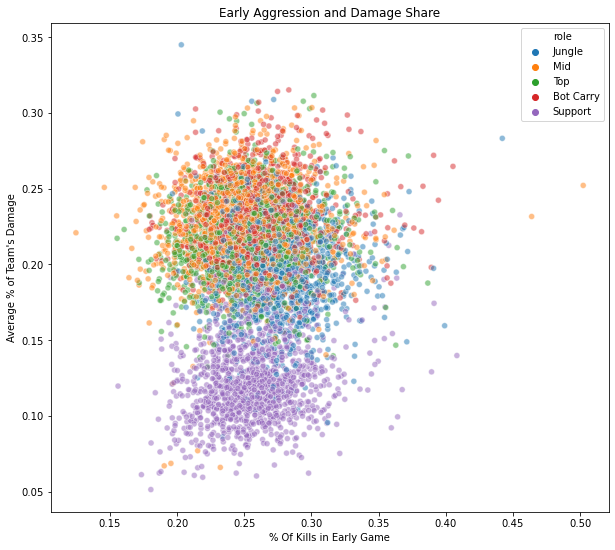

In [10]:
plt.figure(figsize=(10,9))
sns.scatterplot(data=x, x='kda_early', y='dmg_share', alpha=.5, hue='role')
plt.xlabel('% Of Kills in Early Game')
plt.ylabel("Average % of Team's Damage")
plt.title('Early Aggression and Damage Share');

In [ ]:
def ms_to_s(ms):
    return round(ms / 1000)

In [ ]:
na_matches = []
with jsonlines.open('../data/cleaned/matches_na.jsonl') as infile:
    for line in infile:
        na_matches.append(line)
        
        

In [ ]:
na_timelines = []
with jsonlines.open('../data/cleaned/timelines_na.jsonl') as infile:
    for line in infile:
        na_timelines.append(line)

In [ ]:
all_players = []

for match in na_matches:
    for player in match['participantIdentities']:
        all_players.append(player['player']['summonerId'])

players_to_evaluate = pd.Series(all_players).value_counts().reset_index(name="count").query("count > 50")["index"]


In [ ]:
[[(i, event) for event in frame['events'] if event['type'] == 'CHAMPION_KILL' and event['killerId'] == 3] for i, frame in enumerate(ranked_timelines[0]['frames'])]

In [ ]:
ranked_timelines[0]['frames'][11]['events']

In [ ]:
# CSD and XPD @ 15   
# average (kills + assists + deaths) before 15    

ranked_matches[0]['participants']

We want to make sure we are incorporating only full games, where all players were connected and playing, so we will take a look at the distribution of maximum attained level in games which ended between 15 and 16 minutes (you can only initiate a surrender vote at the 15-minute mark). Based on this graph, we will not consider any games in which a player failed to exceed level 7 as valid.

In [ ]:
short_matches = [match for match in ranked_matches if match['gameDuration'] / 60 < 16 and match['gameDuration'] / 60 > 15]
levels = []
for match in short_matches:
    for participant in match['participants']:
        levels.append(participant['stats']['champLevel'])

plt.figure(figsize=(8,5))
sns.distplot(levels, bins=12, kde=False)
plt.xlabel('Max level attained')
plt.ylabel('Count')
plt.title('Distribution of Maximum Level Attained in 15-16 minute games')
plt.xticks(range(1,13));

In [ ]:
players_to_evaluate[0]

In [ ]:
all_players.head()

In [ ]:
ranked_matches[8]